## Setting

In [1]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import imp
import importlib
# sys.path.append("/content/drive/My Drive/LCNN/")


In [2]:
import LCNN
#imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.device_count())
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce RTX 2080 Ti
2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

batchsize=64
dataset_dir = '/home/liu0003/Desktop/datasets'

trainset = datasets.MNIST(dataset_dir, download=True, train=True, transform=transform)
valset = datasets.MNIST(dataset_dir, download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
test_loader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

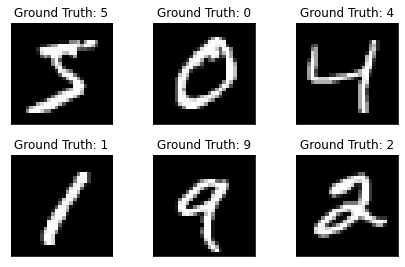

In [4]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# 2 layers network

In [5]:
class NeuralNet2layer(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=False):
        super(NeuralNet2layer, self).__init__()
        self.initialize=initialize
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.batchnorm = batchnorm

        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)


        if self.batchnorm:
            self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        if self.initialize=='NTK':

            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)

            
    def forward(self, x):
        if self.batchnorm:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        else:

            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        return out
    
    
     
def loss_and_accuracy(model,loader, criterion):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    t=0
    c=0
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images)
            loss = criterion(outputs, one_hot(labels, 10)).to(device)
            total_loss += loss
            
            t=t+(torch.argmax(outputs,dim=1) == labels).float().sum()
            c=c+len(outputs)
    return t/c*100, total_loss/c

In [6]:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# images = images.view(images.shape[0], -1).to(device)
# labels =one_hot(labels, 10).to(device)
num_epochs = 20
# total_run_steps = 500
store_every = 10

shared_model_param_dict = {'input_size': 784, 'hidden_size1': 800, 'num_classes': 10, 
                           'num_epochs': num_epochs, 'criterion': nn.MSELoss(), 
                         'train_loader': train_loader, 'test_loader': test_loader, 
                          'store_every': store_every, 'weight_decay': 0}


In [7]:
def mini_batch_train(initialize, batchnorm, learning_rate, weight_decay, input_size, hidden_size1, num_classes, criterion, num_epochs, train_loader, test_loader, store_every ):
    torch.manual_seed(0)
    model = NeuralNet2layer(input_size = input_size, hidden_size1 = hidden_size1, num_classes = num_classes, initialize=initialize,batchnorm = batchnorm).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)


    train_losslist=[]
    train_aclist=[]

    test_losslist=[]
    test_aclist=[]
    
    iter_list = []

    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.view(images.shape[0], -1).to(device)
            labels =one_hot(labels, 10).to(device)
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        iter_list.append(epoch)
        train_ac, train_loss =loss_and_accuracy(model, train_loader , criterion)
        test_ac, test_loss =loss_and_accuracy(model, test_loader , criterion)

        train_losslist.append(train_loss)
        train_aclist.append(train_ac)

        test_losslist.append(test_loss)
        test_aclist.append(test_ac)

        print ('Epoch: %03d/%03d | Train Loss: %.8f | Train acc: %.4f' %(epoch, num_epochs, train_loss, train_ac))   
        
    loss_dict = {'train': train_losslist, 'test': test_losslist}
    acl_dict = {'train': train_aclist, 'test': test_aclist}
    return iter_list, loss_dict, acl_dict

In [17]:

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12 
    
fig_save_path = './Figures/minibatch/'




def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
def plot_loss_acc(step_list, loss_dict, acc_dict, title, fig_save_path, yticks_range = range(95,100)):
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))


    axs[0].plot(step_list, loss_dict['train'], label = 'train', linewidth = 3 ,  linestyle =  '--')
    axs[0].plot(step_list,loss_dict['test'], label = 'test', linewidth = 3)
    axs[0].legend(frameon = False, fontsize = 12)
    axs[0].set_xlabel('Epoch num', fontsize = 15)
    axs[0].set_ylabel('Loss', fontsize = 15)


    axs[1].plot(step_list, acc_dict['train'], label = 'train', linewidth = 3, linestyle =  '--')
    axs[1].plot(step_list, acc_dict['test'], label = 'test', linewidth = 3)
    axs[1].legend(frameon = False, fontsize = 12)
    axs[1].set_xlabel('Epoch num', fontsize = 15)
    axs[1].set_ylabel('Acc', fontsize = 15)
    axs[1].set_yticks(yticks_range)

    plt.suptitle(title, fontsize = 17)

    axs[0] = simpleaxis(axs[0])
    axs[1] = simpleaxis(axs[1])
    plt.subplots_adjust(bottom=0.2)
    plt.savefig(fig_save_path + title, format='png')
    
    return fig

# No scaling, no batch norm

In [9]:
epoch_list, loss_no_scale_no_bn, aclist_no_scale_no_bn = mini_batch_train(initialize = 'LeCun', batchnorm = False, learning_rate = 0.1, ** shared_model_param_dict)

Epoch: 000/020 | Train Loss: 0.00024703 | Train acc: 94.5633
Epoch: 001/020 | Train Loss: 0.00019731 | Train acc: 96.1650
Epoch: 002/020 | Train Loss: 0.00017005 | Train acc: 96.9467
Epoch: 003/020 | Train Loss: 0.00015551 | Train acc: 97.3250
Epoch: 004/020 | Train Loss: 0.00014573 | Train acc: 97.6583
Epoch: 005/020 | Train Loss: 0.00014004 | Train acc: 97.9167
Epoch: 006/020 | Train Loss: 0.00013451 | Train acc: 98.0783
Epoch: 007/020 | Train Loss: 0.00012727 | Train acc: 98.2283
Epoch: 008/020 | Train Loss: 0.00012353 | Train acc: 98.3333
Epoch: 009/020 | Train Loss: 0.00012030 | Train acc: 98.4300
Epoch: 010/020 | Train Loss: 0.00011720 | Train acc: 98.5333
Epoch: 011/020 | Train Loss: 0.00011287 | Train acc: 98.6050
Epoch: 012/020 | Train Loss: 0.00011059 | Train acc: 98.6967
Epoch: 013/020 | Train Loss: 0.00010894 | Train acc: 98.7617
Epoch: 014/020 | Train Loss: 0.00010788 | Train acc: 98.8433
Epoch: 015/020 | Train Loss: 0.00010532 | Train acc: 98.9167
Epoch: 016/020 | Train L

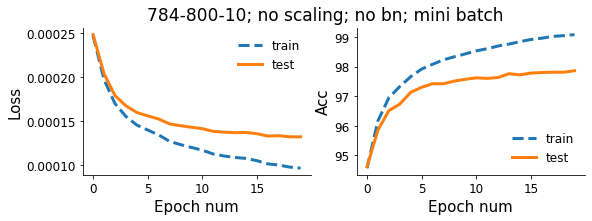

In [18]:
title = '784-800-10; no scaling; no bn; mini batch'
fig = plot_loss_acc(epoch_list, loss_no_scale_no_bn, aclist_no_scale_no_bn, title, fig_save_path)
del title

# No scaling + batch norm

In [11]:
epoch_list, loss_no_scale_bn, aclist_no_scale_bn = mini_batch_train(initialize = 'LeCun', batchnorm = True, learning_rate = 0.1, ** shared_model_param_dict)

Epoch: 000/020 | Train Loss: 0.00053904 | Train acc: 93.7000
Epoch: 001/020 | Train Loss: 0.00033481 | Train acc: 96.2433
Epoch: 002/020 | Train Loss: 0.00029809 | Train acc: 96.9950
Epoch: 003/020 | Train Loss: 0.00022743 | Train acc: 97.5617
Epoch: 004/020 | Train Loss: 0.00023009 | Train acc: 97.8133
Epoch: 005/020 | Train Loss: 0.00024050 | Train acc: 98.0400
Epoch: 006/020 | Train Loss: 0.00019643 | Train acc: 98.3567
Epoch: 007/020 | Train Loss: 0.00018102 | Train acc: 98.5783
Epoch: 008/020 | Train Loss: 0.00017624 | Train acc: 98.6467
Epoch: 009/020 | Train Loss: 0.00017016 | Train acc: 98.7467
Epoch: 010/020 | Train Loss: 0.00016605 | Train acc: 98.8217
Epoch: 011/020 | Train Loss: 0.00015849 | Train acc: 98.8983
Epoch: 012/020 | Train Loss: 0.00014864 | Train acc: 99.0117
Epoch: 013/020 | Train Loss: 0.00014105 | Train acc: 99.0867
Epoch: 014/020 | Train Loss: 0.00013411 | Train acc: 99.1667
Epoch: 015/020 | Train Loss: 0.00012835 | Train acc: 99.2400
Epoch: 016/020 | Train L

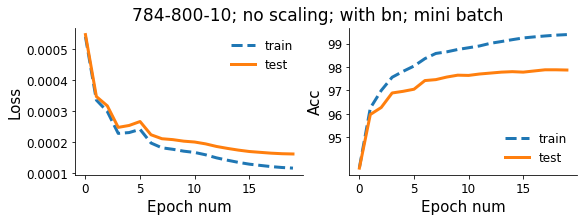

In [19]:
title = '784-800-10; no scaling; with bn; mini batch'
fig = plot_loss_acc(epoch_list, loss_no_scale_bn, aclist_no_scale_bn, title, fig_save_path)
del title

# NTK scaling, no batch norm

In [13]:
epoch_list, loss_ntk_scale_no_bn, aclist_ntk_scale_no_bn = mini_batch_train(initialize = 'NTK', batchnorm = False, learning_rate = 0.1 * np.sqrt(784), ** shared_model_param_dict)

Epoch: 000/020 | Train Loss: 0.00051391 | Train acc: 88.3033
Epoch: 001/020 | Train Loss: 0.00040811 | Train acc: 90.9817
Epoch: 002/020 | Train Loss: 0.00035328 | Train acc: 92.4300
Epoch: 003/020 | Train Loss: 0.00031991 | Train acc: 93.3167
Epoch: 004/020 | Train Loss: 0.00029645 | Train acc: 93.9650
Epoch: 005/020 | Train Loss: 0.00027885 | Train acc: 94.4533
Epoch: 006/020 | Train Loss: 0.00026482 | Train acc: 94.8433
Epoch: 007/020 | Train Loss: 0.00025324 | Train acc: 95.1567
Epoch: 008/020 | Train Loss: 0.00024337 | Train acc: 95.4100
Epoch: 009/020 | Train Loss: 0.00023486 | Train acc: 95.6250
Epoch: 010/020 | Train Loss: 0.00022733 | Train acc: 95.8167
Epoch: 011/020 | Train Loss: 0.00022063 | Train acc: 95.9917
Epoch: 012/020 | Train Loss: 0.00021461 | Train acc: 96.1617
Epoch: 013/020 | Train Loss: 0.00020916 | Train acc: 96.3067
Epoch: 014/020 | Train Loss: 0.00020412 | Train acc: 96.4267
Epoch: 015/020 | Train Loss: 0.00019954 | Train acc: 96.5333
Epoch: 016/020 | Train L

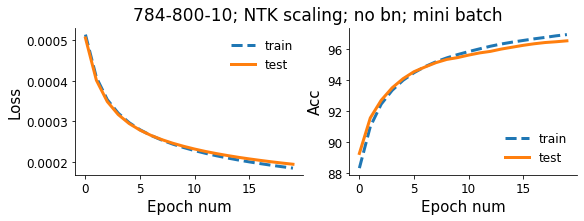

In [24]:
title = '784-800-10; NTK scaling; no bn; mini batch'
fig = plot_loss_acc(epoch_list, loss_ntk_scale_no_bn, aclist_ntk_scale_no_bn, title, fig_save_path, yticks_range = range(88, 98, 2))
del title

# NTK scaling + batch norm

In [15]:
epoch_list, loss_ntk_scale_bn, aclist_ntk_scale_bn =  mini_batch_train(initialize = 'NTK', batchnorm = True, learning_rate =  0.1 * np.sqrt(784), ** shared_model_param_dict)

Epoch: 000/020 | Train Loss: 0.00037993 | Train acc: 92.3100
Epoch: 001/020 | Train Loss: 0.00032077 | Train acc: 93.7750
Epoch: 002/020 | Train Loss: 0.00028986 | Train acc: 94.5467
Epoch: 003/020 | Train Loss: 0.00026923 | Train acc: 95.0050
Epoch: 004/020 | Train Loss: 0.00025378 | Train acc: 95.3867
Epoch: 005/020 | Train Loss: 0.00024173 | Train acc: 95.6783
Epoch: 006/020 | Train Loss: 0.00023194 | Train acc: 95.9117
Epoch: 007/020 | Train Loss: 0.00022379 | Train acc: 96.1517
Epoch: 008/020 | Train Loss: 0.00021668 | Train acc: 96.3467
Epoch: 009/020 | Train Loss: 0.00021049 | Train acc: 96.5233
Epoch: 010/020 | Train Loss: 0.00020505 | Train acc: 96.6483
Epoch: 011/020 | Train Loss: 0.00020020 | Train acc: 96.7750
Epoch: 012/020 | Train Loss: 0.00019586 | Train acc: 96.8883
Epoch: 013/020 | Train Loss: 0.00019185 | Train acc: 96.9967
Epoch: 014/020 | Train Loss: 0.00018823 | Train acc: 97.1000
Epoch: 015/020 | Train Loss: 0.00018485 | Train acc: 97.1717
Epoch: 016/020 | Train L

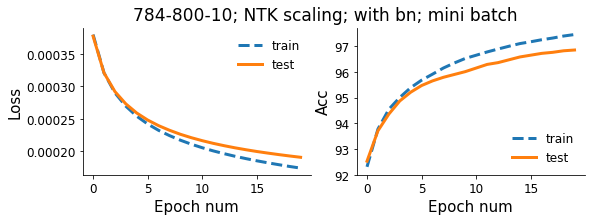

In [27]:
title = '784-800-10; NTK scaling; with bn; mini batch'
fig = plot_loss_acc(epoch_list, loss_ntk_scale_bn, aclist_ntk_scale_bn, title, fig_save_path, yticks_range = range(92, 98, 1))
del title